In [2]:
import seaborn as sns 
import matplotlib.pyplot as plt 
import os
import pandas as pd 
import numpy as np

# set max column 
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

In [3]:
all_files = os.listdir('collected_results/')
# concat
df = pd.concat((pd.read_csv('collected_results/' + f) for f in all_files))

In [89]:
df.columns

Index(['prior_to_model_building', 'after_model_building',
       'pytorch_total_params', 'before_first_batch_0', 'after_first_batch_0',
       'before_model_forward_0', 'after_model_forward_0', 'before_loss_0',
       'after_loss_0', 'before_first_batch_3', 'after_first_batch_3',
       'before_model_forward_3', 'after_model_forward_3', 'before_loss_3',
       'after_loss_3', 'device_name', 'device_total_memory', 'num_threads',
       'model_size_mb', 'max_memory_mb', 'python_ver', 'pytorch_ver',
       'pytorch_lightning_ver', 'data_name', 'model_name', 'seq_len',
       'label_len', 'pred_len', 'features', 'exp_num', 'exp_seed', 'use_amp',
       'cpu_thread', 'num_workers', 'batch_size', 'test_loss', 'mae', 'mse',
       'train_epoch', 'train_batch', 'secs/batch', 'secs/epoch', 'model_hpams',
       'PERSON', 'Unnamed: 0'],
      dtype='object')

In [4]:
## 1. Check if there is a difference between the same devices
v100_subset_df = df[df['device_name'] == 'Tesla V100-PCIE-32GB']
v100_etth1_subset_df = v100_subset_df[v100_subset_df['data_name'] == 'ETTh1']

In [5]:
v100_etth1_subset_df.groupby(['PERSON','data_name','pytorch_ver','use_amp','model_name','seq_len','pred_len'])[['max_memory_mb','mae', 'mse','secs/batch', 'secs/epoch']].describe().loc[:,(slice(None),['mean','std'])]

max_memory_mb  \
                                                                                     mean   
PERSON          data_name pytorch_ver  use_amp model_name  seq_len pred_len                 
JAEHO           ETTh1     1.10.0+cu111 False   Dlinear     96      96           26.076160   
                                                                   720         133.757696   
                                               Informer    96      96         1609.570816   
                                                                   720        6505.579179   
                                               Transformer 96      96         2090.335232   
                                                                   720       10820.090197   
                                       True    Dlinear     96      96           22.400000   
                                                                   720         112.399616   
                                               Informer    96      96         1077.488128   
                                                                   720        3529.241856   
                                               Transformer 96      96         1412.451840   
                                                                   720        7338.380971   
JAEHO_V100_NIPA ETTh1     1.8.1        False   Dlinear     96      96           26.076160   
                                                                   720         133.757696   
                                               Informer    96      96         2338.976256   
                                                                   720       10908.518656   
                                               Transformer 96      96         2706.547883   
                                                                   720       10317.303808   
                                       True    Dlinear     96      96           22.400000   
                                                                   720         112.399616   
                                               Informer    96      96         1353.095936   
                                                                   720        5779.414528   
                                               Transformer 96      96         1609.112320   
                                                                   720        7813.794901   

                                                                                          \
                                                                                     std   
PERSON          data_name pytorch_ver  use_amp model_name  seq_len pred_len                
JAEHO           ETTh1     1.10.0+cu111 False   Dlinear     96      96           0.513194   
                                                                   720          2.070444   
                                               Informer    96      96         919.130121   
                                                                   720       4140.067543   
                                               Transformer 96      96        1238.754154   
                                                                   720       6983.276699   
                                       True    Dlinear     96      96           0.442525   
                                                                   720          1.793936   
                                               Informer    96      96         546.076130   
                                                                   720       2169.560143   
                                               Transformer 96      96         776.798675   
                                                                   720       4683.861315   
JAEHO_V100_NIPA ETTh1     1.8.1        False   Dlinear     96      96           0.513194   
                                                                   720          2.070444   


## 1-1  within the same V100 GPU

In [6]:

nipa_server = v100_etth1_subset_df[v100_etth1_subset_df['PERSON']=='JAEHO']
nipa_server_96_batch32 = nipa_server[(nipa_server['pred_len']==96) & (nipa_server['batch_size']==32)]
nipa_server_720_batch32 = nipa_server[(nipa_server['pred_len']==720) & (nipa_server['batch_size']==32)]

nipa_server_96_batch128 = nipa_server[(nipa_server['pred_len']==96) & (nipa_server['batch_size']==128)]
nipa_server_720_batch128 = nipa_server[(nipa_server['pred_len']==720) & (nipa_server['batch_size']==128)]

In [38]:
def make_catplot_maxmb(df, batch_size, y_limit, title, save_name=None):
    # set y limit
    g = sns.catplot(
        data=df, kind="bar",
        x="model_name", y="max_memory_mb", hue="use_amp",
        errorbar="sd", palette="dark", alpha=.6, height=6, order=['Transformer','Informer','Dlinear'],
    )
    g.legend.set_title("Using AMP Backend", prop={'size': 14, 'weight': 'bold'})
    # set figure title
    # set white grid 

    g.fig.suptitle(title, fontsize=18, fontweight='bold', y=1.05)
    # set ylim of catplot
    g.set(ylim=(0, y_limit))
    # set y label
    g.set_ylabels('Max Memory (MB)', fontsize=14, fontweight='bold')
    # set x label
    g.set_xlabels('Model Name', fontsize=14, fontweight='bold')
    # set x tick label
    g.set_xticklabels(fontsize=12, fontweight='bold')

    if save_name is not None:
        g.savefig(f"figures/{save_name}_maxmb.png", dpi=300)
    
    

In [19]:
sns.set_theme(style="whitegrid")

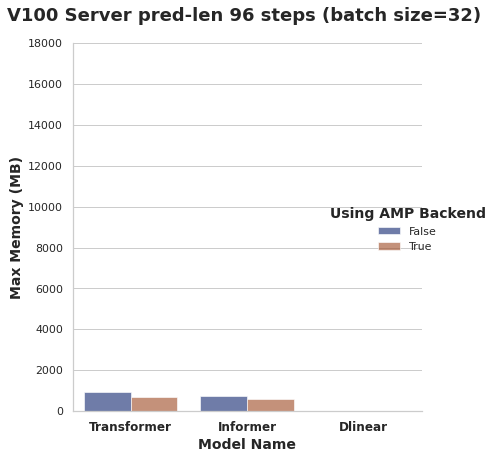

In [39]:
make_catplot_maxmb(nipa_server_96_batch32, 
            batch_size=32, 
            y_limit=18000, 
            title= "V100 Server pred-len 96 steps (batch size=32)",
            save_name="v100_server_96_batch32")

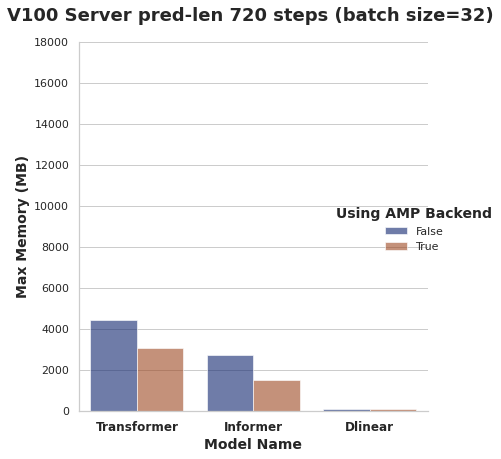

In [40]:
make_catplot_maxmb(nipa_server_720_batch32,
            batch_size=32,
            y_limit=18000,
            title= "V100 Server pred-len 720 steps (batch size=32)",
            save_name="v100_server_720_batch32")
            

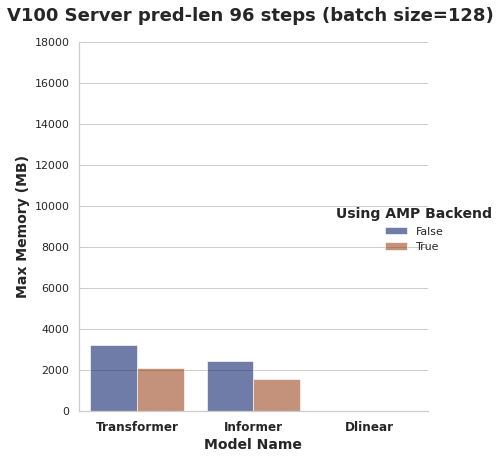

In [41]:
make_catplot_maxmb(nipa_server_96_batch128, 
            batch_size=128, 
            y_limit=18000, 
            title= "V100 Server pred-len 96 steps (batch size=128)",
            save_name="v100_server_96_batch128")

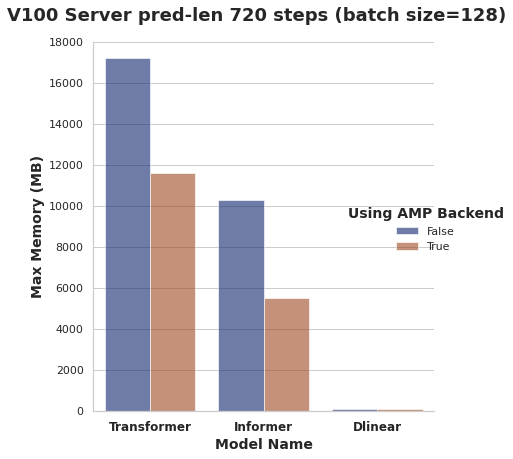

In [42]:
make_catplot_maxmb(nipa_server_720_batch128,
            batch_size=128,
            y_limit=18000,
            title= "V100 Server pred-len 720 steps (batch size=128)",
            save_name="v100_server_720_batch128")

In [81]:
def make_catplot_batchsec(df, batch_size, y_limit, title, save_name=None):
    # set y limit
    g = sns.catplot(
        data=df, kind="bar",
        x="model_name", y="secs/batch", hue="use_amp",
        errorbar="sd", palette="dark", alpha=.6, height=6, order=['Transformer','Informer','Dlinear'],
    )
    g.legend.set_title("Using AMP Backend", prop={'size': 14, 'weight': 'bold'})
    # set figure title
    # set white grid 

    g.fig.suptitle(title, fontsize=18, fontweight='bold', y=1.05)
    # set ylim of catplot
    g.set(ylim=(0, y_limit))
    # set y label
    g.set_ylabels('Second (Batch/sec)', fontsize=14, fontweight='bold')
    # set x label
    g.set_xlabels('Model Name', fontsize=14, fontweight='bold')
    # set x tick label
    g.set_xticklabels(fontsize=12, fontweight='bold')

    if save_name is not None:
        g.savefig(f"figures/{save_name}_secbatch.png", dpi=300)
    
    

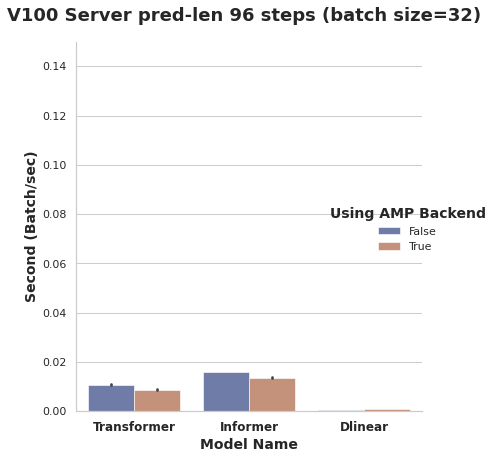

In [82]:
make_catplot_batchsec(nipa_server_96_batch32,
            batch_size=32,
            y_limit=0.15,
            title= "V100 Server pred-len 96 steps (batch size=32)",
            save_name="v100_server_96_batch32")

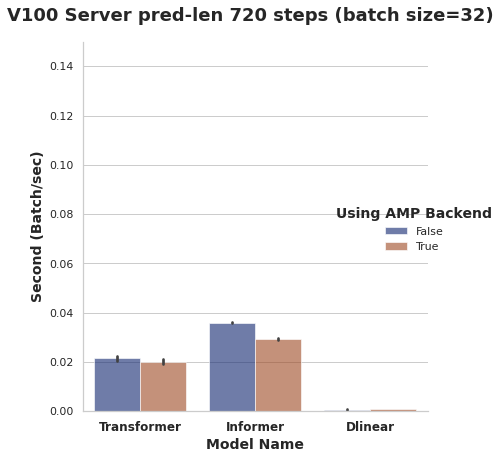

In [83]:
make_catplot_batchsec(nipa_server_720_batch32,
            batch_size=32,
            y_limit=0.15,
            title= "V100 Server pred-len 720 steps (batch size=32)",
            save_name="v100_server_720_batch32")

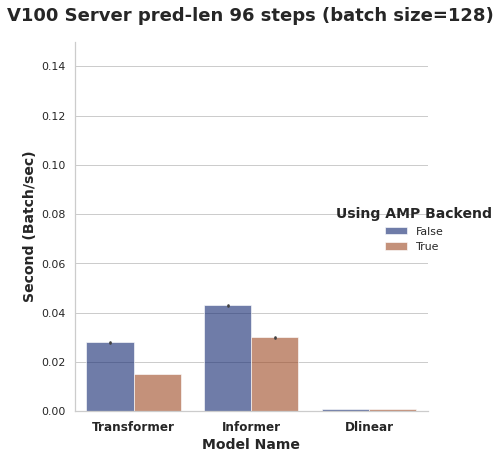

In [84]:
make_catplot_batchsec(nipa_server_96_batch128,
            batch_size=128,
            y_limit=0.15,    
            title= "V100 Server pred-len 96 steps (batch size=128)",
            save_name="v100_server_96_batch128")

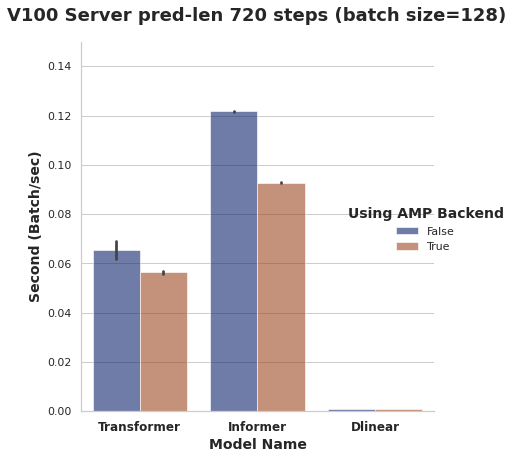

In [85]:
make_catplot_batchsec(nipa_server_720_batch128,
            batch_size=128,
            y_limit=0.15,
            title= "V100 Server pred-len 720 steps (batch size=128)",
            save_name="v100_server_720_batch128")

In [14]:
nipa_server_720_batch32.groupby(['use_amp','model_name','pred_len'])['secs/batch'].describe()

count      mean       std       min       25%  \
use_amp model_name  pred_len                                                  
False   Dlinear     720         3.0  0.000719  0.000019  0.000699  0.000710   
        Informer    720         3.0  0.035959  0.000105  0.035839  0.035929   
        Transformer 720         3.0  0.021482  0.000872  0.020485  0.021171   
True    Dlinear     720         3.0  0.000835  0.000006  0.000830  0.000831   
        Informer    720         3.0  0.029448  0.000330  0.029159  0.029268   
        Transformer 720         3.0  0.020207  0.000859  0.019585  0.019717   

                                   50%       75%       max  
use_amp model_name  pred_len                                
False   Dlinear     720       0.000720  0.000729  0.000738  
        Informer    720       0.036019  0.036020  0.036020  
        Transformer 720       0.021857  0.021981  0.022104  
True    Dlinear     720       0.000832  0.000837  0.000842  
        Informer    720       0.029377  0.029593  0.029808  
        Transformer 720       0.019849  0.020518  0.021187

# Within the same V100, different pytorch version

In [75]:

v100_data = v100_etth1_subset_df[v100_etth1_subset_df['use_amp']==True]
v100_96_batch32 = v100_data[(v100_data['pred_len']==96) & (v100_data['batch_size']==32)]
v100_720_batch32 = v100_data[(v100_data['pred_len']==720) & (v100_data['batch_size']==32)]
v100_96_batch128 = v100_data[(v100_data['pred_len']==96) & (v100_data['batch_size']==128)]
v100_720_batch128 = v100_data[(v100_data['pred_len']==720) & (v100_data['batch_size']==128)]
v100_data.groupby(['PERSON','model_name','pytorch_ver','pred_len','batch_size'])['max_memory_mb'].describe()


count  \
PERSON          model_name  pytorch_ver  pred_len batch_size          
JAEHO           Dlinear     1.10.0+cu111 96       32            3.0   
                                                  128           3.0   
                                         720      32            3.0   
                                                  128           3.0   
                Informer    1.10.0+cu111 96       32            3.0   
                                                  128           3.0   
                                         720      32            3.0   
                                                  128           3.0   
                Transformer 1.10.0+cu111 96       32            3.0   
                                                  128           3.0   
                                         720      32            3.0   
                                                  128           3.0   
JAEHO_V100_NIPA Dlinear     1.8.1        96       32            3.0   
                                                  128           3.0   
                                         720      32            3.0   
                                                  128           3.0   
                Informer    1.8.1        96       32            3.0   
                                                  128           3.0   
                                         720      32            3.0   
                                                  128           3.0   
                Transformer 1.8.1        96       32            3.0   
                                                  128           3.0   
                                         720      32            3.0   
                                                  128           3.0   

                                                                      mean  \
PERSON          model_name  pytorch_ver  pred_len batch_size                 
JAEHO           Dlinear     1.10.0+cu111 96       32             22.803968   
                                                  128            21.996032   
                                         720      32            114.037248   
                                                  128           110.761984   
                Informer    1.10.0+cu111 96       32            578.991104   
                                                  128          1575.985152   
                                         720      32           1548.713472   
                                                  128          5509.770240   
                Transformer 1.10.0+cu111 96       32            703.334912   
                                                  128          2121.568768   
                                         720      32           3062.620160   
                                                  128         11614.141781   
JAEHO_V100_NIPA Dlinear     1.8.1        96       32             22.803968   
                                                  128            21.996032   
                                         720      32            114.037248   
                                                  128           110.761984   
                Informer    1.8.1        96       32            678.180352   
                                                  128          2028.011520   
                                         720      32           2448.765440   
                                                  128          9110.063616   
                Transformer 1.8.1        96       32            782.504448   
                                                  128          2435.720192   
                                         720      32           3261.448875   
                                                  128         12366.140928   

                                                                       std  \
PERSON          model_name  pytorch_ver  pred_len batch_size                 
JAEHO           Dlinear     1.

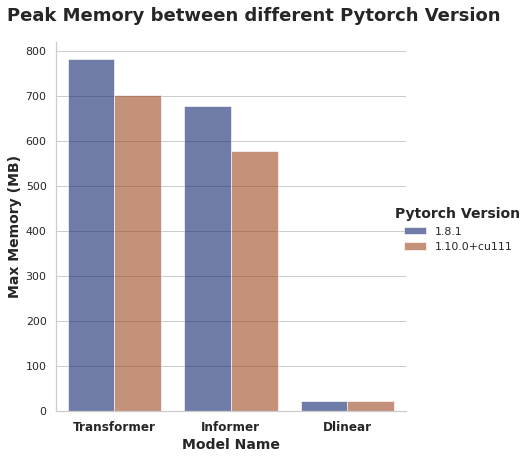

In [80]:
g = sns.catplot(
    data=v100_96_batch32, kind="bar",
    x="model_name", y="max_memory_mb", hue="pytorch_ver",
    errorbar="sd", palette="dark", alpha=.6, height=6, order=['Transformer','Informer','Dlinear'],
    hue_order=['1.8.1','1.10.0+cu111']
)
g.legend.set_title("Pytorch Version", prop={'size': 14, 'weight': 'bold'})
# # set figure title
# # set white grid 

g.fig.suptitle("Peak Memory between different Pytorch Version", fontsize=18, fontweight='bold', y=1.05)
# # set ylim of catplot
# g.set(ylim=(0, y_limit))
# # set y label
g.set_ylabels('Max Memory (MB)', fontsize=14, fontweight='bold')
# set x label
g.set_xlabels('Model Name', fontsize=14, fontweight='bold')
# set x tick label
g.set_xticklabels(fontsize=12, fontweight='bold')

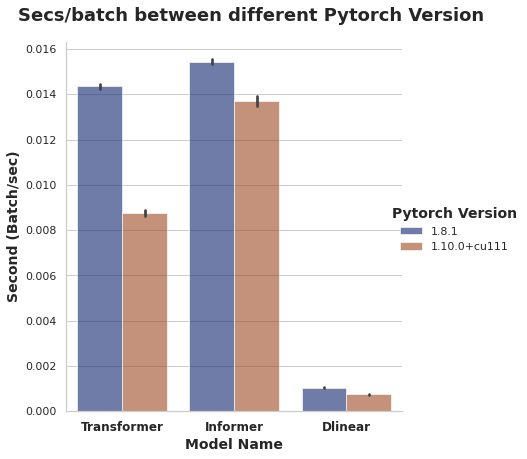

In [88]:
g = sns.catplot(
    data=v100_96_batch32, kind="bar",
    x="model_name", y="secs/batch", hue="pytorch_ver",
    errorbar="sd", palette="dark", alpha=.6, height=6, order=['Transformer','Informer','Dlinear'],
    hue_order=['1.8.1','1.10.0+cu111']
)
g.legend.set_title("Pytorch Version", prop={'size': 14, 'weight': 'bold'})
# # set figure title
# # set white grid 

g.fig.suptitle("Secs/batch between different Pytorch Version", fontsize=18, fontweight='bold', y=1.05)
# # set ylim of catplot
# g.set(ylim=(0, y_limit))
# # set y label
g.set_ylabels('Second (Batch/sec)', fontsize=14, fontweight='bold')
# set x label
g.set_xlabels('Model Name', fontsize=14, fontweight='bold')
# set x tick label
g.set_xticklabels(fontsize=12, fontweight='bold')